In [1]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Basis for much of this: https://jfin-swufe.springeropen.com/track/pdf/10.1186/s40854-020-00217-x.pdf

# Personal Project - Compare the ability to predict cryptocurrency and futures prices using machine learning

## Start with acquiring crypto data
- Will acquire Bitcoin, Ethereum, and Litecoin data as these have some of the longest price histories and greatest liquidity

In [2]:
desired_products = ['BTC-USD',
 'ETH-USD',
 'LTC-USD']

In [3]:
results = acquire.get_data_from_csv()

In [4]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


In [5]:
btc=prepared_results['BTC_USD']

In [6]:
btc.isna().sum()

time      0
low       0
high      0
open      0
close     0
volume    0
dtype: int64

No nulls

In [7]:
btc.describe()

,low,high,open,close,volume
count,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000
mean,15367.271296,16353.665287,15891.738578,15910.606708,14627.887462
std,16901.301024,17955.831798,17468.665539,17473.333789,11638.656327
min,568.120000,573.310000,570.830000,570.840000,683.798071
25%,4082.865000,4365.630000,4249.675000,4258.360000,7144.589967
50%,8215.660000,8760.430000,8522.300000,8525.070000,11718.880202
75%,17445.630000,18601.875000,17830.325000,17940.440000,18296.256136
max,66261.790000,69000.000000,67554.130000,67554.840000,130316.646844


Min btc value of 0.06 is suspicious and should be corrected

In [8]:
# Incorporated into prepare
btc.index[btc.low == 0.06]

# Gather minute data from that day to fix the low value
# minute_data = acquire.acquire_crypto_data(acquire.get_full_product_info(['BTC-USD']),datetime(2017, 4, 15, 0,0,0), datetime(2017, 4, 15, 23, 59, 0), 60)

# minute_data['BTC-USD']=minute_data['BTC-USD'].loc[(minute_data['BTC-USD'].index<'2017-04-15 23:00:00' )|(minute_data['BTC-USD'].index>'2017-04-15 23:50:00')]

# minute_data['BTC-USD'].low.min()

# btc.loc['2017-04-15','low'] = minute_data['BTC-USD'].low.min()

DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)

In [9]:
# auth_client = cbpro.AuthenticatedClient(api_key, secret_key, passphrase)

In [10]:
# desired_products_with_info = acquire.get_full_product_info(desired_products)

In [11]:
# results = acquire.acquire_crypto_data(desired_products_with_info, datetime.now()-timedelta(days=3000), datetime.now(), minute_bars=86400)

Text(0.5, 1.0, 'Bitcoin data starts earliest\nDifferent currencies clearly at different scales')

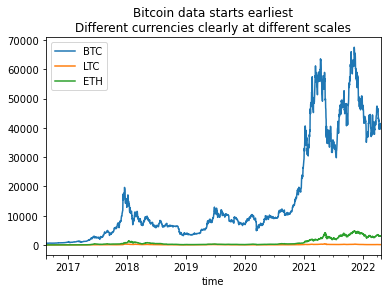

In [12]:
results['BTC_USD'].close.plot(label='BTC')
results['LTC_USD'].close.plot(label='LTC')
results['ETH_USD'].close.plot(label='ETH')
plt.legend()
plt.title('Bitcoin data starts earliest\nDifferent currencies clearly at different scales')

In [13]:
print('Min data bitcoin: ',results['BTC_USD'].index.min())
print('Min data litecoin: ',results['LTC_USD'].index.min())
print('Min data ethereum: ',results['ETH_USD'].index.min())

Min data bitcoin:  2016-08-17 00:00:00
Min data litecoin:  2016-08-17 00:00:00
Min data ethereum:  2016-08-17 00:00:00


Will truncate data so all starts at same day

### Volatility:
- relative price range: RR
- range volatility estimator of Parkinson: sigma  - lags 1-7

#### Lagged log returns, 1-7 days earlier

In [14]:
btc = prepare.add_features(btc)

## Add target and features (all added to prepare.py file)

In [15]:
# # forward 1 day log returns
# btc["log_ret_fwd"] = np.log(btc.close) - np.log(btc.close.shift(-1))
# # forward standard returns
# btc["ret_fwd"] = btc.close.shift(-1) - btc.close
# btc["pct_chg"] = btc.close.pct_change()

In [16]:
# for i in range(1,8):
#     btc[f'log_ret_lag_{i}'] = np.log(df.close) - np.log(df.close.shift(i))

## Split data

In [17]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

<AxesSubplot:xlabel='time'>

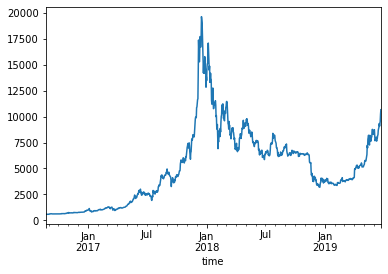

In [18]:
train.close.plot()

In [19]:
train.columns

Index(['time', 'low', 'high', 'open', 'close', 'volume', 'log_ret_fwd',
       'ret_fwd', 'fwd_pct_chg', 'next_close_positive', 'pct_chg',
       'log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday'],
      dtype='object')

<AxesSubplot:xlabel='time'>

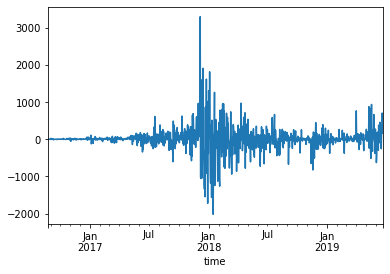

In [20]:
train.ret_fwd.plot()

<AxesSubplot:xlabel='time'>

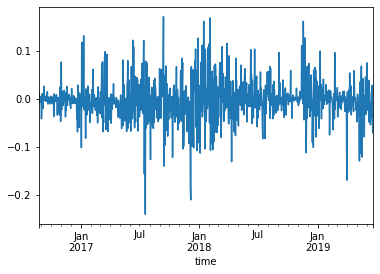

In [21]:
train.log_ret_fwd.plot()

In [26]:
train.corrwith(train.log_ret_fwd)

low                    0.066747
high                   0.066128
open                   0.068015
close                  0.065933
volume                -0.031338
log_ret_fwd            1.000000
ret_fwd               -0.827821
fwd_pct_chg            0.998780
next_close_positive   -0.667871
pct_chg                0.012351
log_ret_lag_1          0.011469
log_ret_lag_2         -0.020126
log_ret_lag_3         -0.031387
log_ret_lag_4         -0.005556
log_ret_lag_5         -0.037157
log_ret_lag_6         -0.049871
log_ret_lag_7         -0.036887
RR                    -0.018527
sigma_lag_1           -0.018403
sigma_lag_2           -0.045426
sigma_lag_3           -0.012200
sigma_lag_4            0.016418
sigma_lag_5            0.039582
sigma_lag_6           -0.047553
sigma_lag_7           -0.015279
day_name_Friday       -0.037741
day_name_Monday       -0.015143
day_name_Saturday      0.018027
day_name_Sunday       -0.008098
day_name_Thursday      0.006189
day_name_Tuesday       0.018902
day_name